In [7]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

In [8]:
def sine(X, signal_freq=60.):
    return np.sin(2* np.pi * (X) / signal_freq)

def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size = Y.shape)
    return Y + noise

def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out


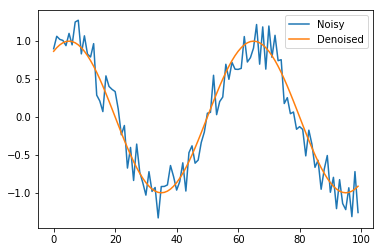

In [9]:
inp, out = sample(100)
plt.plot(inp, label = 'Noisy')
plt.plot(out, label = 'Denoised')
plt.legend()

In [10]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [11]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [17]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred
    
r = CustomRNN(input_dim, hidden_size, 1)      

In [18]:
r

CustomRNN(
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
  (act): Tanh()
)

In [19]:
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

C:\Users\aryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


0 tensor(0.5943)
20 tensor(0.1188)
40 tensor(0.1057)
60 tensor(0.1025)
80 tensor(0.0916)
100 tensor(0.0768)
120 tensor(0.0717)
140 tensor(0.0764)
160 tensor(0.0622)
180 tensor(0.0610)
200 tensor(0.0559)
220 tensor(0.0516)
240 tensor(0.0513)
260 tensor(0.0501)
280 tensor(0.0473)
300 tensor(0.0515)


In [20]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1,1))), requires_grad=True)
pred_t = r(t_inp)

Text(0.5,1,'Sample num: 23')

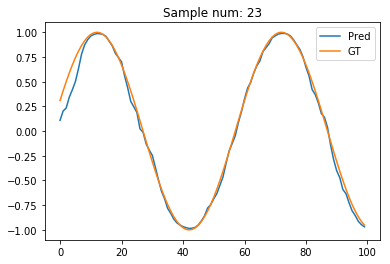

In [21]:
sample_num = 23
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.plot(test_out[sample_num],label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))